In [44]:
import datetime
from calculator import LoanContext
from calculator.rates import InterestContext, InflationContext
from calculator.loans.downpayments import DownPayments
from calculator.loans.indexedloan import IndexBasedLoan

lcontext = LoanContext(40000000, datetime.datetime.now(), 25)
icontext = InterestContext(2.94)
fcontext = InflationContext(10)
dpayments = DownPayments(lcontext, icontext)
a = IndexBasedLoan(dpayments, fcontext)
a.df['payments_base'] += 130
a.df

,date,cumulative_inflation,capital_base,payments_base,payments_extra,interests_base,instalments_base
0,2023-04-03 22:13:13.468182,0.008333,4.033333e+07,190138.915364,0,98816.666667,89621.927082
1,2023-05-03 22:13:13.468182,0.008333,4.024296e+07,190142.803503,0,98595.263164,89843.330585
2,2023-06-03 22:13:13.468182,0.008333,4.015237e+07,190146.710164,0,98373.312703,90065.281046
3,2023-07-03 22:13:13.468182,0.008333,4.006156e+07,190150.635519,0,98150.813932,90287.779817
4,2023-08-03 22:13:13.468182,0.008333,3.997052e+07,190154.579744,0,97927.765496,90510.828253
...,...,...,...,...,...,...,...
297,2048-01-03 22:13:13.468182,0.008333,7.929585e+05,265745.717794,0,1942.748294,186495.845455
298,2048-02-03 22:13:13.468182,0.008333,6.049085e+05,303696.227713,0,1482.025850,186956.567900
299,2048-03-03 22:13:13.468182,0.008333,4.163940e+05,417544.135952,0,1020.165228,187418.428521
300,2048-04-03 22:13:13.468182,0.008333,2.274137e+05,228100.885584,0,557.163619,187881.430130


In [48]:
import numpy as np


def indexed_based_even_payment(capital, inflation, interest_rate, payment_idx, n_payments, extra_payment = 0):

    if payment_idx == 0:
        raise Exception("0-day payment not supported.")

    monthly_interest = interest_rate / 12
    monthly_interest_increase = 1 + monthly_interest
    payment_interest = monthly_interest_increase**(n_payments - payment_idx + 1)

    monthly_inflation = np.exp(np.log(1 + inflation) / 12) - 1
    inflated_capital = capital * (1 + monthly_inflation)

    if n_payments == payment_idx:
        payment = inflated_capital * (1 + monthly_interest)
    else:
        payment = inflated_capital * payment_interest * monthly_interest / (payment_interest - 1)
    interest = inflated_capital * monthly_interest
    installment = payment - interest
    capital_after = inflated_capital - installment - extra_payment

    return payment, interest, capital_after

indexed_based_even_payment(40000000, 10.0/100, 2.94/100, 1, 300)

(189941.22955786713, 98781.46576203256, 40227805.85336031)

In [49]:
def indexed_based_fixed_installment(capital, inflation, interest_rate, payment_idx, n_payments, extra_payment = 0):

    if payment_idx == 0:
        raise Exception("0-day payment not supported.")

    monthly_interest = interest_rate / 12

    monthly_inflation = np.exp(np.log(1 + inflation) / 12) - 1
    inflated_capital = capital * (1 + monthly_inflation)

    installment = inflated_capital / (n_payments  - payment_idx + 1)
    interest = inflated_capital * monthly_interest
    payment = installment + interest
    capital_after = inflated_capital - installment - extra_payment

    return payment, interest, capital_after

indexed_based_fixed_installment(40000000, 10.0/100, 2.94/100, 1, 300)

(233178.01781921973, 98781.46576203256, 40184569.06509896)

In [ ]:
def indexed_based_even_payment(capital, inflation, interest_rate, payment_idx, n_payments, extra_payment = 0):

    if payment_idx == 0:
        raise Exception("0-day payment not supported.")

    monthly_interest = interest_rate / 12
    monthly_interest_increase = 1 + monthly_interest
    payment_interest = monthly_interest_increase**(n_payments - payment_idx + 1)

    monthly_inflation = np.exp(np.log(1 + inflation) / 12) - 1
    inflated_capital = capital * (1 + monthly_inflation)

    if n_payments == payment_idx:
        payment = inflated_capital * (1 + monthly_interest)
    else:
        payment = inflated_capital * payment_interest * monthly_interest / (payment_interest - 1)
    interest = inflated_capital * monthly_interest
    installment = payment - interest
    capital_after = inflated_capital - installment - extra_payment

    return payment, interest, capital_after

<Axes: >

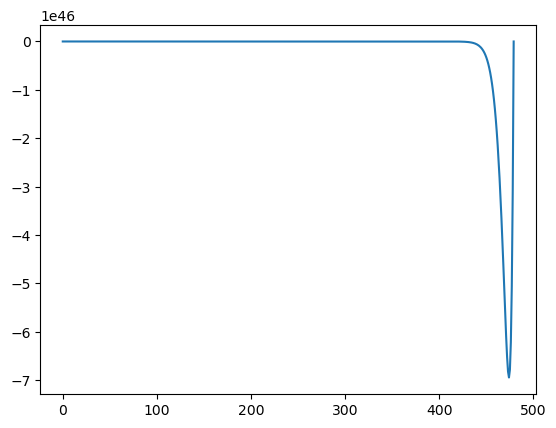

In [28]:
import pandas as pd


class LoanCalculator:

    @classmethod
    def monthly_inflation_rate(cls, inflation: float) -> float:
        return np.exp(np.log(1 + inflation) / 12) - 1

    @classmethod
    def monthly_inflation_interest(cls, inflation: float) -> float:
        return 1 + cls.monthly_inflation_rate(inflation)

    @classmethod
    def monthly_rate(cls, interest: float) -> float:
        return interest / 12

    @classmethod
    def monthly_interest(cls, interest: float) -> float:
        return 1 + cls.monthly_rate(interest)

    @classmethod
    def inflated_capital(cls, capital: float, inflation: float) -> float:
        return capital * cls.monthly_inflation_interest(inflation)

    @classmethod
    def adjusted_interest(cls, interest: float, payment_idx: int, n_payments: int) -> float:
        return cls.monthly_interest(interest) ** (n_payments - payment_idx + 1)

    @classmethod
    def payment_interest(cls, capital: float, interest: float) -> float:
        return capital * cls.monthly_rate(interest)

    @classmethod
    def even_payments(cls, capital: float, inflation: float, interest: float, payment_idx: int, n_payments: int):
        if payment_idx == 0:
            raise Exception("0-day payment not supported.")

        capital_inflated = cls.inflated_capital(capital, inflation)
        if n_payments == payment_idx:
            payment = capital_inflated * (1 + cls.monthly_rate(interest))
        else:
            pi = cls.adjusted_interest(interest, payment_idx, n_payments)
            payment = capital_inflated * pi * cls.monthly_rate(interest) / (pi - 1)

        interest = cls.payment_interest(capital_inflated, interest)
        installment = payment - interest
        capital_after = capital_inflated - installment

        return capital_after, installment, interest

    @classmethod
    def fixed_installments(cls, capital: float, inflation: float, interest: float, payment_idx: int, n_payments: int):
        capital_inflated = cls.inflated_capital(capital, inflation)
        installment = capital_inflated / (n_payments - payment_idx + 1)
        interest = capital_inflated * cls.monthly_rate(interest)
        capital_after = capital_inflated - installment

        return capital_after, installment, interest

class Loans:
    def __init__(self, property_value: float, capital: float, inflation: float, interest: float, n_payments: int):
        self.property_value = property_value
        self.capital = capital
        self.inflation = inflation
        self.interest = interest
        self.n_payments = n_payments

    def initialize_dataframe(self) -> pd.DataFrame:
        columns = ['property_value', 'capital', 'installments', 'interests', 'monthly_payment', 'liquidation_value']
        data = np.empty((self.n_payments, len(columns)))
        data[:] = np.nan
        return pd.DataFrame(data, columns=columns)

    def append_dataframe(self, df, idx, capital, installments, interests):
        property_value = LoanCalculator.inflated_capital(self.property_value, self.inflation)
        df.loc[idx] = {
            'property_value': property_value,
            'capital': capital,
            'installments': installments,
            'interests': interests,
            'monthly_payment': installments + interests,
            'liquidation_value': property_value - capital
        }
        return df

    def calculate(self, loan_type: str, use_inflation: bool) -> pd.DataFrame:

        if loan_type == 'even':
            if use_inflation:
                calculator = LoanCalculator.fixed_installments
            else:
                calculator = lambda c, i, r, pi, pn: LoanCalculator.fixed_installments(c, i*0, r, pi, pn)
        elif loan_type == 'fixed':
            if use_inflation:
                calculator = LoanCalculator.even_payments
            else:
                calculator = lambda c, i, r, pi, pn: LoanCalculator.even_payments(c, i*0, r, pi, pn)
        else:
            raise Exception('Loan type is either even or fixed.')

        capital = self.capital
        df = self.initialize_dataframe()
        payment = 1
        while capital > 0.1:
            c, p, i = calculator(capital, self.inflation * use_inflation, self.interest, payment, self.n_payments)
            self.append_dataframe(df, payment-1, c, p, i)
            capital = c
            payment += 1
        return df


%matplotlib inline
df = Loans(60000000, 40000000, 10.0, 2.0, 12*40).calculate('even', True)

